По итогам соревнований по анализу данных и машинному обучению, полезным бывает изучать поведение участников во время соревнований. Это может быть как просто занимательная статистика, так и призыв к действию: кроссвалидация -- наше всё. Станут видны, некоторые особенности, которые свойственны соревнованиям, которых стоит придерживаться. Они общеизвестны, но говорить стоит о них как можно чаще. Это важно.

Я не буду останавливаться на структуре подобного рода соревнований и рассказывать о том, как они проводятся. Об этом написано в других статьях как на [Хабре](https://habr.com/ru/company/ods/blog/426227/), так и в других [источниках](https://www.kaggle.com/docs/competitions). Предполагая, что мой читатель в курсе всей этой, кухни, сразу перейду к делу.

Речь пойдёт о чемпионате на платформе [boosters.pro](https://boosters.pro), который был подготовлен вместе с Росбанком, за что им большое спасибо. На мой вкус [соревнование](https://boosters.pro/champ_21) выдалось хорошим. Шафл был минимальный, а данные на трейне и привате по распределению примерно совпадали. В частности об этом говорил на презентации Кирилл Хрыльченко (3 место). Кроме того, можно было попарсить датку из разных источников (дозволялось практически всё) и прикрутить их к модели. Датасет представлял собой наборы банкоматов-точек (координаты long, lat) и небольшую метаинфу к ним. Требовалось построить алгоритм, который мог бы отвечать на вопрос о величине индекса популярности банкомата -- безразмерная величина, получаемая банком. Метрика: RMSE. Да, кстати, орги предоставили [baseline](https://boosters.pro/uploads/champs/champ_21/baseline.ipynb). 

Для того, чтобы дать представление о задаче, познакомим читателей с датасетом.

# Анализ данных соревнования

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import json
from jq import jq

fontsize = 18
figsize_small = (10, 7)
figsize_ordinary = (15, 10)
markersize_ordinary = 14
markersize_big = 20
linewidth = 4

data_path = 'data/'
picts_path = 'picts/'

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
plt.style.use('seaborn')

Загрузим все данные

In [2]:
train = pd.read_csv('../data/train.csv', index_col=0)
test = pd.read_csv('../data/test.csv', index_col=0)
test = test.rename(columns={'atm_group': 'bank'})
train = train.rename(columns={'atm_group': 'bank'})

In [3]:
train.head()

,id,bank,address,address_rus,lat,long,target
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277


In [4]:
test.head()

,id,bank,address,address_rus,lat,long
0,8096.0,5478.0,"D. 97, UL. KIROVA NOVOKUZNETSK","улица Кирова, 97, Новокузнецк, Кемеровская обл...",53.757824,87.159786
1,2570.0,3185.5,UL. SERGEJA MAKEEVA MOSKVA,NaN,NaN,NaN
2,2428.0,3185.5,"UL.NAHIMOVA, DOM 33 VILJUCHINSK","улица Нахимова, 33, жилой район Рыбачий, Вилюч...",52.918598,158.514038
3,2799.0,3185.5,MKR 3 D 13B SHAR SHARYPOVO,"3-й микрорайон, Шарыпово, Красноярский край, Р...",55.533496,89.178148
4,250.0,1942.0,29 CHICHERINA STR. CHELYABINSK,"улица Чичерина, 29, Челябинск, Россия, 454128",55.179216,61.297729


Приведём к интам id-банкоматов

In [5]:
test['bank'] = np.uint(test['bank'] * 10)
train['bank'] = np.uint(train['bank'] * 10)

Зафиксируем тест и трейн

In [6]:
train['is_train'] = True
test['is_train'] = False
test['index'] = test.index + 1
train['index'] = train.index + 1
train['train_index'] = train.index + 1
test['test_index'] = test.index + 1
train['test_index'] = 0
test['train_index'] = 0
train['index'] = train.index
train['id'] = train['id'].astype(np.uint)
test['id'] = test['id'].astype(np.uint)

Некоторые адреса не содержат расшифровок координат. Отметим их и попутно объединим всё в одну таблицу

In [7]:
data_all = train.append(test, sort=False)

data_all['address_fail'] = 0
data_all.at[data_all['address_rus'].isnull(), 'address_fail'] = 1

data_all['address_rus'] = data_all['address_rus'].fillna('')

In [8]:
data_all.head()

,id,bank,address,address_rus,lat,long,target,is_train,index,train_index,test_index,address_fail
0,8526,320,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,True,0,1,0,0
1,8532,320,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,True,1,2,0,0
2,8533,320,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,True,2,3,0,0
3,8684,320,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,True,3,4,0,0
4,37,320,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,True,4,5,0,0


In [9]:
def custom_settings(pict_name_=None, xlabel_='', ylabel_='', x_min_=0.04, x_max_=0.048, y_min_=0.04, y_max_=0.048, fontsize_=fontsize, grid_=True, xticks=[None, None], yticks=[None, None], title_=''):
    plt.xlabel(xlabel_, fontsize=fontsize_)
    plt.ylabel(ylabel_, fontsize=fontsize_)
    plt.xticks(xticks[0], xticks[1], fontsize=fontsize_)
    plt.yticks(yticks[0], yticks[1], fontsize=fontsize_)
    plt.legend(fontsize=fontsize_)
    plt.xlim([x_min_, x_max_])
    plt.ylim([y_min_, y_max_])
    plt.title(title_, fontsize=fontsize)
    plt.grid(grid_)

    if pict_name_ is not None:
        plt.savefig(picts_path+pict_name_)
    

def custom_plot(x_, y_, figsize_=figsize_ordinary, color_='', label_='', linewidth_=linewidth, markersize_=None):
    if figsize_ is not None:
        plt.figure(figsize=figsize_)
    x_ = pd.DataFrame(list(zip(x_, y_))).dropna().values[:, 0]
    y_ = pd.DataFrame(list(zip(x_, y_))).dropna().values[:, 1]
    plt.plot(x_, y_, color_, label=label_, linewidth=linewidth_, markersize=markersize_)

### Id и Target

Взглянем на распределение таргетов. Это всегда интересно сделать. В этой задаче, взяв лишь только Id и целевую переменную можно кое-что получить. Сами поглядите:

No handles with labels found to put in legend.


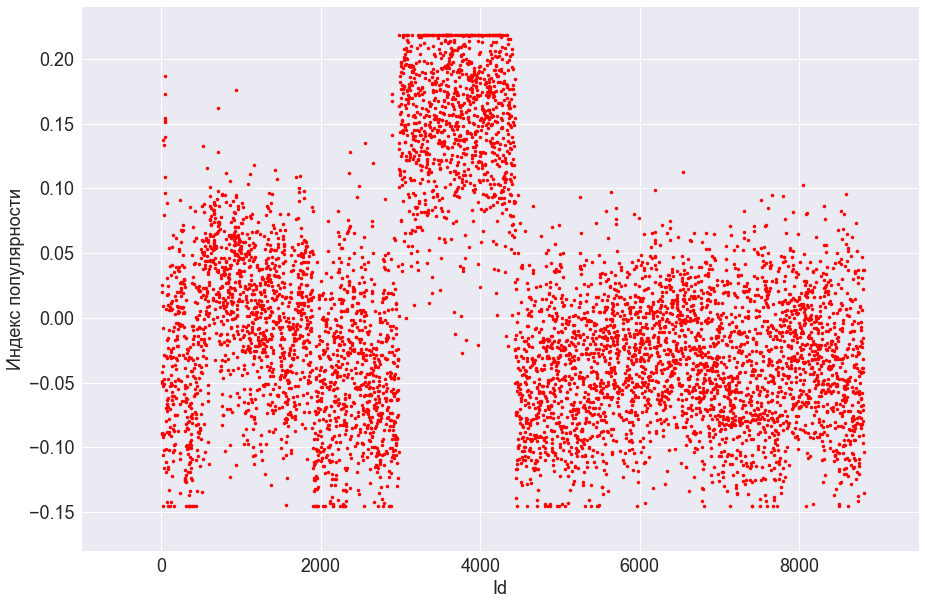

In [10]:
kwargs = {
    'x_': data_all['id'].values, 
    'y_': data_all['target'], 
    'color_': 'r.',
    'linewidth_': linewidth, 
}
custom_plot(**kwargs)

kwargs = {
    'x_min_': -1000,
    'x_max_': 9500,
    'y_min_': -0.18,
    'y_max_': 0.24,
    'xlabel_': 'Id',
    'ylabel_': 'Индекс популярности',
    'pict_name_': '2.png',
}
custom_settings(**kwargs)

В качестве бейзлайна можно было разделить точки на очевидные кластеры. Тогда ответом для объекта из кластера, считать медиану, или, на худой конец, среднее. Небольшое улучшение: убрать пограничные точки, -- те, которые находятся далеко от центров кластеров.

Эти группы объясняются очень просто: у банкоматов разных банков, индекс популярности, в среднем, различный. 

Возникает вопрос: почему индекс популярности отрицательный? Ребята из Росбанка, вероятнее всего, применили std-scale нормировку, образевав краевые очень большие и очень малые значения в датасете. Вот мы и получили такое распредление.

Таким образом, в данном соревновании, как можно догадаться, затаскивали Id.

### Координаты (Long) и Target

Оценим совместное распределение координат и целевой переменной. Выкинем все NaN:

In [11]:
y_label = 'target'
col = 'long'
df = data_all[[col, y_label]].dropna()

km = KMeans(n_clusters=70, n_init=30, max_iter=300, random_state=42)
km.fit([[k]for k in list(df[col].values)])
l = km.labels_

No handles with labels found to put in legend.


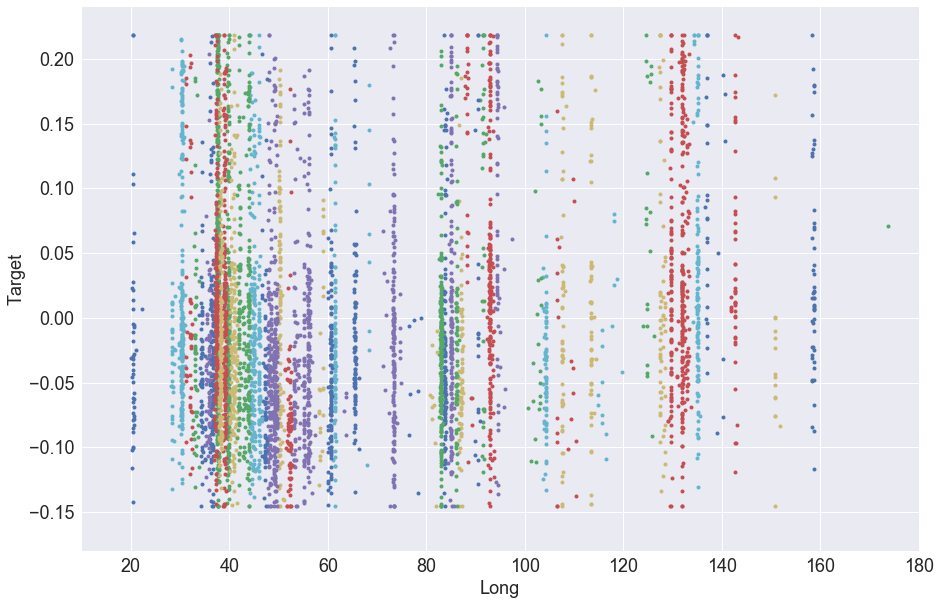

In [12]:
figsize = figsize_ordinary
for i in np.unique(l):
    x = df[col].values[l == i]
    y = df[y_label].values[l == i]
    kwargs = {
        'figsize_': figsize,
        'x_': x, 
        'y_': y,
        'color_': '.', 
        'markersize_': 8,
        'linewidth_': linewidth, 
    }
    figsize = None 
    custom_plot(**kwargs)

kwargs = {
    'x_min_': 10,
    'x_max_': 180,
    'y_min_': -0.18,
    'y_max_': 0.24,
    'xlabel_': 'Long',
    'ylabel_': 'Target',
    'pict_name_': '3.png',
}
custom_settings(**kwargs)

In [13]:
del df

Мы видим вертикально ориентированные кластера. Их природа состоит в том, что каждый кластер представляет собой город. При этом, есть мелкие города и сёла, в которых есть всего несколько банкоматов. В районе $\text{Long} \in [30$-$40]$ увеличивается плотность. Она соответствует Москве и Питеру. Другие крупные кластера, в подавляющем большинстве -- областные центры.

### Результаты соревнования. Анализ сабмитов

Чтобы читатели понимали, как получилась статья, следует рассказать вот что. Сначала я подготовил небольшую презентацию и выступил на митапе по итогам соревнования. Оказалось, что мой доклад (откровенно плохо рассказанный) нескольким людям таки приглянулся. Поэтому я решил сделать небольшую статью на эту тему и выложить её на Хабр. Данные для доклада я брал исключительно основываясь на паблике и прайвате. Для статьи же я использовал в том числе данные, которые предоставили мне ребята из boosters.pro. Поэтому ниже будут результаты, полученные только по публичным данным и результаты на основе приватных данных от boosters.pro.

В качестве данных для анализа, у меня имеются:

* Информация с лидерборда (паблик и приват). Публичные данные
* Сабмиты участников (предоставили организаторы). Приватные данные

Загрузим публичную часть:

In [14]:
def get_rating(l, step):
    return [l[i:i+step] for i in range(0, len(l), step)]

with open(data_path+'private') as fd:
    l = fd.readlines()[1:-1]
    step = 3
    private_rating = get_rating(l, step)
    
with open(data_path+'public') as fd:
    step = 5
    l = fd.readlines()[1:-1]
    public_rating = get_rating(l, step)

In [15]:
df_private = pd.DataFrame(private_rating[1:], columns=['PositionPrivate', 'Name', 'PrivateScore'])
df_public = pd.DataFrame(public_rating[1:], columns=['PositionPublic', 'Name', 'CountSubmission', 'PublicScore', 'Date'])
df = pd.merge(df_public, df_private, on='Name')
df['PublicScore'] = df['PublicScore'].astype(np.float)
df['PrivateScore'] = df['PrivateScore'].astype(np.float)
df['PositionPublic'] = df['PositionPublic'].astype(np.int)
df['PositionPrivate'] = df['PositionPrivate'].astype(np.int)
df['CountSubmission'] = df['CountSubmission'].astype(np.int)
df['IsParticipant'] = True

In [16]:
new_df = pd.DataFrame([[np.int(228), 'Baseline', np.int(1), 0.046853, '2018-11-22 00:00:00', np.int(225), 0.045365, False]], columns=df.columns, index=[df.shape[0]])
df = df.append(new_df)
new_df = pd.DataFrame([[np.int(50), 'Top-50', np.int(1), 0.044089, '2018-11-22 00:00:00', np.int(50), 0.043449, False]], columns=df.columns, index=[df.shape[0]])
df = df.append(new_df)
del new_df

In [17]:
df['Date'] = pd.to_datetime(df['Date'])

Загрузка сабмитов из json в pandas (приватная чать):

In [18]:
submits = json.load(open(data_path+'solutions.json'))
jq_script = '[.[] | {"id": ._id, "private_score": .solutions | [.[].score_private], "date": .solutions | [.[].date], "is_final": .solutions | [.[].isFinal], "public_score": .solutions | [.[].score]}]'
submits = jq(jq_script).transform(submits)

columns = ['id', 'private_score', 'public_score', 'date', 'is_final']
s = []
for submit in submits:
    s += list(zip(
        [submit['id']] * len(submit['private_score']), 
        submit['private_score'],
        submit['public_score'], 
        submit['date'], 
        submit['is_final']
    ))
submits = s
del s

submits = pd.DataFrame(submits, columns=columns)

In [19]:
submits['date'] = pd.to_datetime(submits['date'])
submits['validate'] = submits['public_score'] != -2

Для затравочки, посмотрим, как сабмитили люди. Поработаем с публичной частью датасета. Возьмём все лучшие сабмиты, которые делали люди и построим гистограмму

No handles with labels found to put in legend.


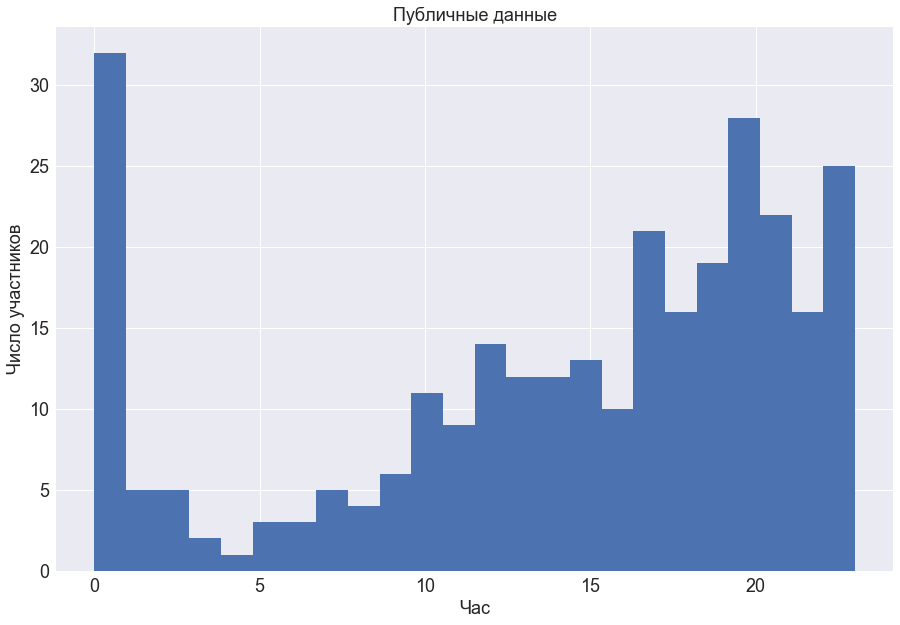

In [20]:
plt.figure(figsize=figsize_ordinary)
plt.hist(df['Date'].apply(lambda el: el.hour), bins=24)

kwargs = {
    'x_min_': None, 'x_max_': None, 'y_min_': None, 'y_max_': None,
    'xlabel_': 'Час',
    'ylabel_': 'Число участников',
    'pict_name_': '4.png',
    'title_': 'Публичные данные',
}
custom_settings(**kwargs)

Занятно, что много людей сделало самый клёвый сабмит вечером или сразу после 00:00. Т.е. скорее всего это выглядело так: пилим-пилим-пилим, до 12 не успел сделать решение, расстроился и запушил уже после 00:00 что-нибудь и пошёл спать. Но такое распределение характерно только для лучших сабмитов участников. 

Если же добавить данные по всем сабмитам (график ниже), то увидим, что вообще говоря, люди сабмитят в основном вечером и уж никак не сразу после 12. Этому эффекту я так и не нашёл объяснения, хотя проверил различные гипотезы.

В будние дни особая активность начинается в 7 утра (встал - бегом за комп делать сабмит), в обед, в 14 (забьём на еду) и вечером в 18 (перед выездом домой с работки), а затем, спустя 2 часа (ещё разок засабмитим что-нибудь уже дома). В выходные, к моему удивлению, люди делают сабмиты, в основном, только лишь вечером и примерно в одно и то же время.

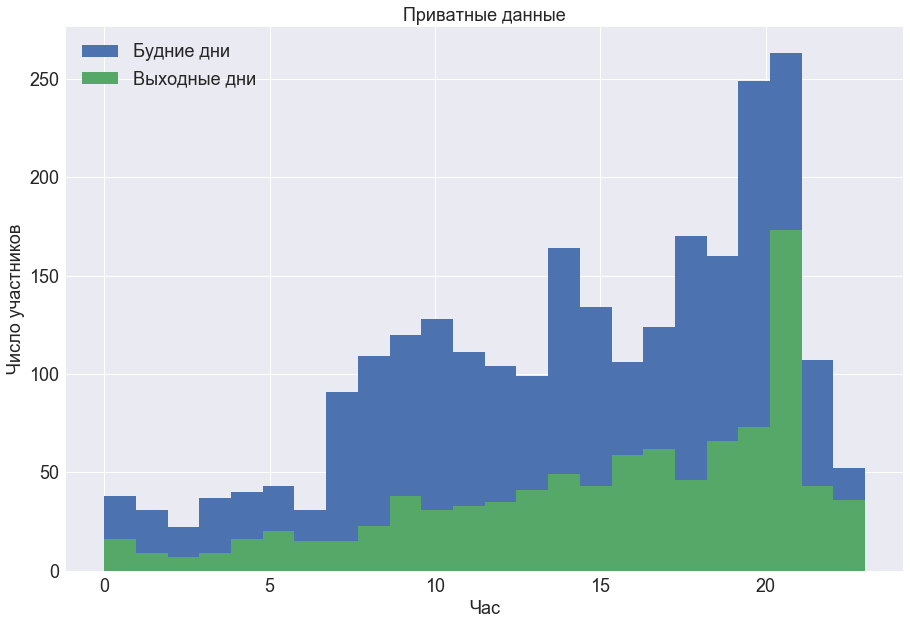

In [21]:
plt.figure(figsize=figsize_ordinary)
mask = (submits['date'].dt.weekday < 5)
plt.hist(submits[mask]['date'].dt.hour, bins=24, label='Будние дни')
mask = (submits['date'].dt.weekday >= 5)
plt.hist(submits[mask]['date'].dt.hour, bins=24, label='Выходные дни')

kwargs = {
    'x_min_': None, 'x_max_': None, 'y_min_': None, 'y_max_': None,
    'xlabel_': 'Час',
    'ylabel_': 'Число участников',
    'pict_name_': '5.png',
    'title_': 'Приватные данные',
}
custom_settings(**kwargs)

Если поглядеть на характер сабмитов по дням за всё время соревнования, то выяснится следующие несколько фактов:

* 31 декабря, вместо того, чтобы пить и тусить люди сабмитили и хотели получить 100к в дополнительной номинации (организаторы обещали человеку, который на 00:00:00 01 января 2019 будет первым, денежку). На пьедестал вырвался ботовод с огромным отрывом ото всех.
* С 1 января по нарастающей все начали сабмитить с пиком в последний день соревнований
* Есть просадка в районе 14 декабря (в т.ч. до и после). Ей явного объяснения нет. Скорее всего, к этому моменту, большинство людей поняли: ключ к победе -- парсить внешние данные. Все принялись парсить яндекс, банки ру и другое добро
* Пик 3 декабря (в т.ч. до и после) объяснить легко. Участники засылали бейзлайны

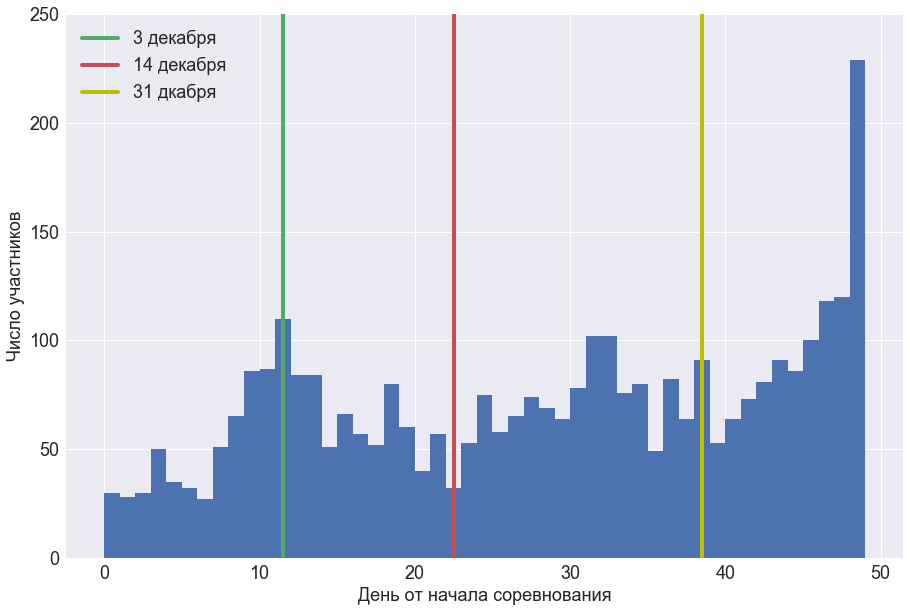

In [22]:
min_date = np.min(submits['date'])
plt.figure(figsize=figsize_ordinary)
plt.hist((submits['date'] - min_date).dt.days, bins=49)
y_max = 250
plt.plot([11.5, 11.5], [0, y_max], linewidth=4, label='3 декабря')
plt.plot([22.5, 22.5], [0, y_max], linewidth=4, label='14 декабря')
plt.plot([38.5, 38.5], [0, y_max], 'y', linewidth=4, label='31 дкабря')
plt.ylim([0, y_max])

kwargs = {
    'x_min_': None, 'x_max_': None, 'y_min_': None, 'y_max_': None,
    'xlabel_': 'День от начала соревнования',
    'ylabel_': 'Число участников',
    'pict_name_': '6.png'
}
custom_settings(**kwargs)

### Результаты соревнования. Алгоритмы участников

Окей, с баловством покончили. Давайте про результаты. Взглянем на самую информативную часть, которая есть в публичной части данных: публичный и приватный скоры. Мы сразу обозначим выжные для нас зависимости и точки:

* Baseline
* Top-50 (все те, кто попал в Топ-50, могли бороться за победы в дополнительных номинациях)
* Прямая y = x

Первые два пункта очевидны и понятны. Последняя прямая отвечает равенству публичного и приватного скора: она отображает ГМТ (геометрическое место точек), которое теоритически должно быть эквивалентно полному отсутствию переобучения. Но, как мы увидим, для реального датасета (в хорошем случае, а именно таким был наш случай), это не так (todo: ввести степень отклонения данных от теоритического). 

In [23]:
def get_coords_by_name(name):
    xPub, yPub = df[df['Name'] == name]['PublicScore'], df[df['Name'] == name]['PrivateScore']
    return xPub, yPub

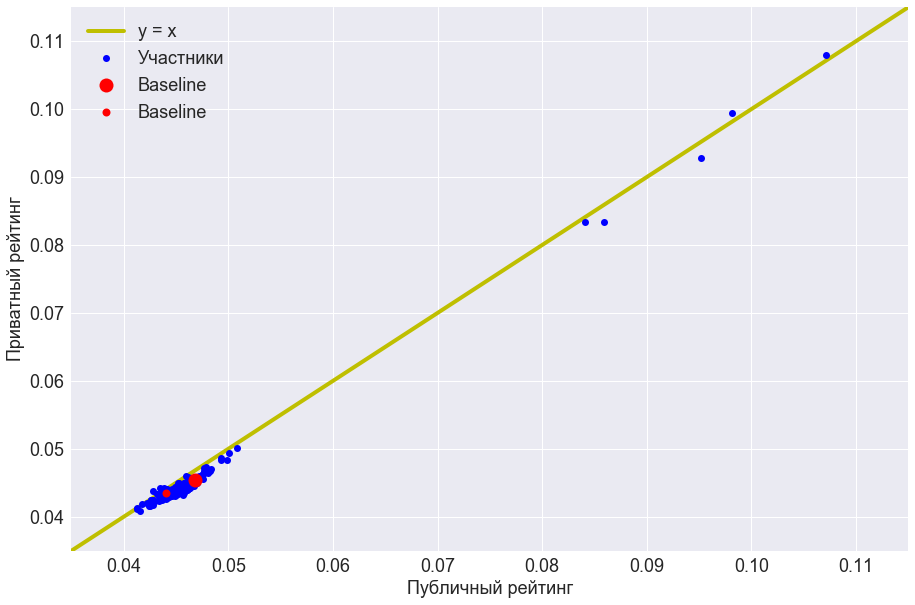

In [24]:
x_min, x_max = 0.035, 0.115
y_min, y_max = 0.035, 0.115
kwargs = {
    'x_': np.linspace(x_min, x_max, 2), 
    'y_': np.linspace(x_min, x_max, 2), 
    'color_': 'y', 
    'label_': 'y = x', 
    'linewidth_': linewidth, 
    'markersize_': markersize_ordinary,
}
custom_plot(**kwargs)

kwargs['x_'] = df['PublicScore']
kwargs['y_'] = df['PrivateScore']
kwargs['color_'] = 'b.'
kwargs['label_'] = 'Участники'
kwargs['figsize_'] = None
custom_plot(**kwargs)


kwargs['x_'], kwargs['y_'] = get_coords_by_name('Baseline')
kwargs['color_'] = 'ro'
kwargs['label_'] = 'Baseline'
kwargs['markersize_'] = markersize_ordinary
custom_plot(**kwargs)

kwargs['x_'], kwargs['y_'] = get_coords_by_name('Top-50')
kwargs['color_'] = 'r.'
kwargs['label_'] = 'Baseline'
kwargs['markersize_'] = 16
custom_plot(**kwargs)


kwargs = {
    'x_min_': x_min,
    'x_max_': x_max,
    'y_min_': y_min,
    'y_max_': y_max,
    'xlabel_': 'Публичный рейтинг',
    'ylabel_': 'Приватный рейтинг',
    'pict_name_': '7.png',
}
custom_settings(**kwargs)

Выбросы. У нас есть 2 группы выбросов:

1. В районе точки $(0.05 0.05)$
2. В первой четверти относительно точки $(0.08, 0.08)$

Скорее всего они объясняются 3-мя причинами: засылка бейзлайнов, ботоводы и неудачные попытки отправки решений без использования предоставленного baseline.

При этом, даже с такими выбросами можно сделать важный вывод, если внимательно присмотреться:

* Основной кластер точек не совсем совпадает с прямой $y=x$. Он, в среднем, отклоняется вниз. 

Это говорит о том, что распределение на тесте и на трейне отличались. Связано это с особенностью данных. Да и датасет был, всё-таки, шумным:

* Адреса, предоставленные оргами не всегда соответствовали действительности (банкоматы в поле, болотах, горах и других интересных местах)
* Часть адресов не заполнено
* Терминалы в закрытых военных городках (это частично объясняет предыдущий пункт)
* Мелкие городки и деревни, в которых был 1 или 2 банкомата
* Банкоматы в центре больших городов (Москва), на центральной улице (Арбат), индекс популярности у которых, ниже плинтуса
* Мелкие группы банкоматов (atm_group, т.е. колонка bank) предсказывались, очевидно, хуже

Выбросим все неадекватные решения и копии бейзлайна

In [25]:
df = df[
    (df['PublicScore'] < 0.048) & \
    (df['PrivateScore'] < 0.048) & \
    (df['PublicScore'] != df[df['Name'] == 'Baseline']['PublicScore'].values[0]) | \
    (~df['IsParticipant'])
]

Взглянем на график, нарисованный в осях public-private. Этот график явно демонстрирует: люди, в среднем, не переобучались.

График $y = x$ показывает все те точки, у которых публичный и приватный скор совпадают. Все решения, которые находятся ниже этого графика, на публичном лидерборде получили прирост. Выше -- получили меньше скора.

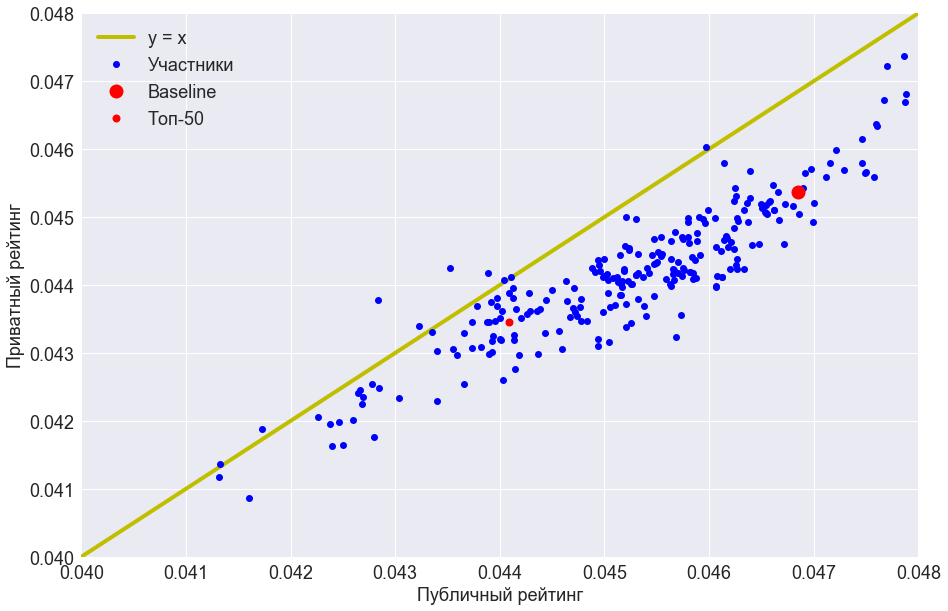

In [26]:
x_min, x_max = 0.04, 0.048
y_min, y_max = 0.04, 0.048
plt.figure(figsize=figsize_ordinary)
plt.plot(np.linspace(x_min, x_max, 2), np.linspace(y_min, y_max, 2), 'y', label='y = x', linewidth=linewidth)

plt.plot(df['PublicScore'], df['PrivateScore'], 'b.', markersize=markersize_ordinary, label='Участники')
xPub, yPub = get_coords_by_name('Baseline')
plt.plot(xPub, yPub, 'ro', markersize=markersize_ordinary, label='Baseline')
xPr, yPr = get_coords_by_name('Top-50')
plt.plot(xPr, yPr, 'r.', markersize=16, label='Топ-50')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('Публичный рейтинг', fontsize=fontsize)
plt.ylabel('Приватный рейтинг', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

plt.savefig(picts_path+'8.png')

С одной стороны, решения, которые лежат ближе всего к этой прямой можно воспринимать как наиболее стабильные. Так бы было, если бы паблик и прайват были распределены в точности одинаково. Но есть некоторая вариация. И она достаточно большая. Люди на паблике боролись за 3-4 знак. На глаз она выглядит довольно большой. Позднее мы это ещё обсудим.

In [35]:
np.random.seed(42)
lr = LinearRegression()
lr.fit(df[['PublicScore']], df[['PrivateScore']]);

def distance(lr, points):
    # Стабильность
    p = np.array(points)
    return ((lr.coef_[0] * p[0] - p[1] + lr.intercept_[0]) / np.sqrt(lr.coef_[0] ** 2 + lr.intercept_[0] ** 2))[0]
df['Stability'] = df.apply(lambda row: distance(lr, row[['PublicScore', 'PrivateScore']].values), axis=1)

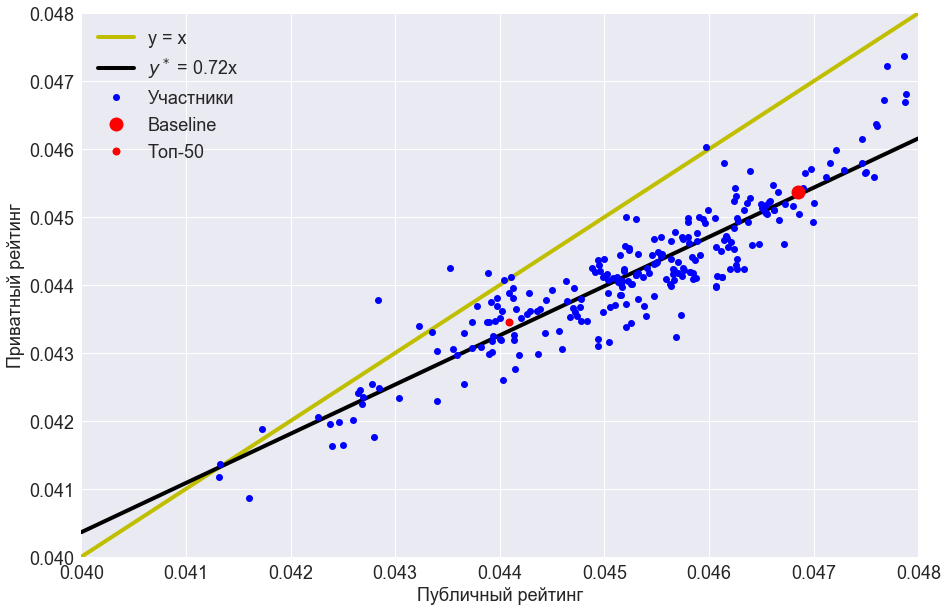

In [36]:
x_min, x_max = 0.04, 0.048
y_min, y_max = 0.04, 0.048
plt.figure(figsize=figsize_ordinary)
plt.plot(np.linspace(x_min, x_max, 2), np.linspace(y_min, y_max, 2), 'y', label='y = x', linewidth=linewidth)

plt.plot([x_min, x_max], lr.predict([[x_min], [x_max]]), 'k-', label='$y^*$ = %.2fx' % lr.coef_, linewidth=linewidth)
plt.plot(df['PublicScore'], df['PrivateScore'], 'b.', markersize=markersize_ordinary, label='Участники')
xPub, yPub = get_coords_by_name('Baseline')
plt.plot(xPub, yPub, 'ro', markersize=markersize_ordinary, label='Baseline')
xPr, yPr = get_coords_by_name('Top-50')
plt.plot(xPr, yPr, 'r.', markersize=16, label='Топ-50')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('Публичный рейтинг', fontsize=fontsize)
plt.ylabel('Приватный рейтинг', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

plt.savefig(picts_path+'9.png')

Тогда принимем во внимание общие тенденции приватного множества: в среднем скор алгоритмов отклоняется от $y=x$ и концентрируются вокруг $y=0.72x$ (данная оценка получена при помощи МНК). Значит наиболее стабильными решениями скорее всего являются близлежащие именно к последней прямой. Тогда мерой стабильности или устойчивости будем считать длину перпендикуляра, восстановленного из соответствующей точки до прямой $y=0.72x$.

В данном случае, стабильность -- важная характеристика не столько для соревнования, сколько для качества алгоритмов. Сильное отклонение от максимально стабильных точек -- это плохо: будь то в плюс (на привате скор сильно вырос) или в минус (на привате скор сильно упал). Выбирая из двух зол, первый случай, разумеется, предпочтительнее. Но он, также как и второй случай, показывает, что на новых данных алгоритм себя ведёт в той или иной степени нестабильно.

Стабильность -- величина степень переобучения, которая характерна для данного приватного множества.

И, всё-таки, кто же из участников переобучился, а кто -- нет? Предлагаю посмотреть на график ниже. Рассмотрим его относительно зелёных осей координат с центром в Топ-50. Эта точка особенно удобна, поскольку она проходит практически через точку Топ-50 и через кривую максимально стабильных решений. Нас особенно будут интересовать 2, 3 и 4 четверти. Все те точки, которые находятся ниже оси абсцисс -- участники, попавшие в Топ-50. 4 четверть -- участники, попавшие в Топ-50 на привате, 2 четверть -- на паблике. В 3ей четверти находятся все те, кто и на паблике и на привате попал в Топ-50. 

Практически у всех, кто участвовал в соревновании скор на привате подрос. Но это вовсе не означает, что люди вовсе не переобучились. 30% людей (14 человек) оказались вне Топ-50 на привате, хотя были таковыми на паблике. Полёты были довольно сильными. Вот небольшая статистика:

In [71]:
print('Число людей, поднявшихся в Топ-50 на привате (покинувших паблик): %d' % (df[df['IsParticipant']].sort_values('PositionPrivate')['PositionPublic'].head(50) > 50).sum())
print('Медианный скор на привате (Топ-50): %f' % df[(df['IsParticipant']) & (df['PositionPrivate'] <= 50)]['PrivateScore'].median())
print('Медианный скор на паблике (Топ-50): %f' % df[(df['IsParticipant']) & (df['PositionPrivate'] <= 50)]['PublicScore'].median())
print('Топ-50 скор на паблике: %f' % df.sort_values('PositionPublic')['PublicScore'].iloc[50])
print('Топ-50 скор на привате: %f' % df.sort_values('PositionPrivate')['PrivateScore'].iloc[50])
print('Медианна прыжков: %d' % np.abs(df['PositionPrivate'] - df['PositionPublic']).median())
print('Максимальный прыжок вниз (с 23 места): %d' % np.abs((df['PositionPrivate'] - df['PositionPublic']).max()))
print('Минимальный прыжок вверх (со 150 места): %d' % np.abs((df['PositionPrivate'] - df['PositionPublic']).min()))

Число людей, поднявшихся в Топ-50 на привате (покинувших паблик): 14
Медианный скор на привате (Топ-50): 0.042984
Медианный скор на паблике (Топ-50): 0.043660
Топ-50 скор на паблике: 0.044089
Топ-50 скор на привате: 0.043449
Медианна прыжков: 17
Максимальный прыжок вниз (с 23 места): 123
Минимальный прыжок вверх (со 150 места): 111




Если скор подрос, то точка лежит ниже жёлтой прямой $y=x$. Например, участники из 3ей четверти, которые лежат ниже жёлтой прямой, получили прирост в скоре на паблике, но вылетели из Топ-50.

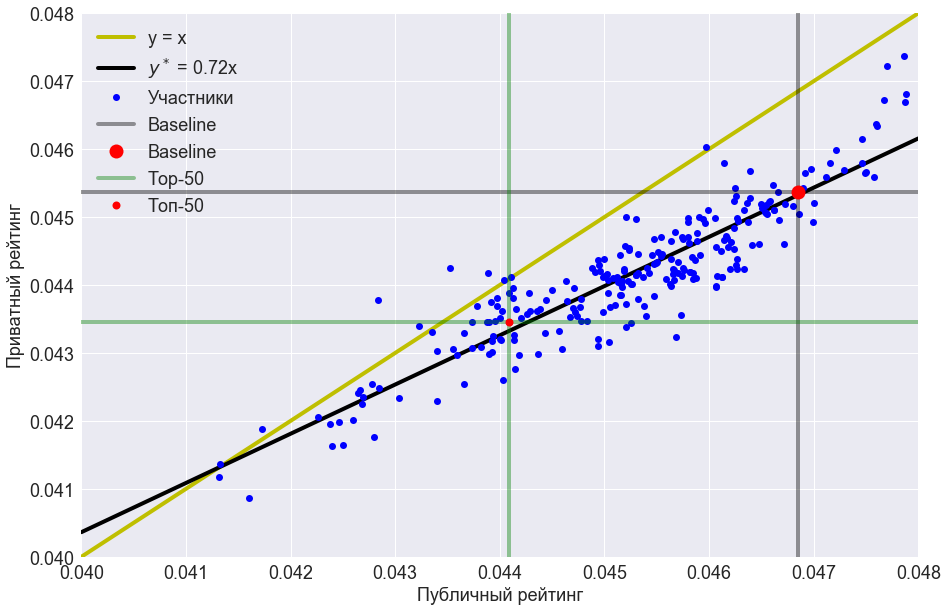

In [37]:
x_min, x_max = 0.04, 0.048
y_min, y_max = 0.04, 0.048
plt.figure(figsize=figsize_ordinary)

plt.plot(np.linspace(x_min, x_max, 2), np.linspace(y_min, y_max, 2), 'y', label='y = x', linewidth=linewidth)

plt.plot([x_min, x_max], lr.predict([[x_min], [x_max]]), 'k-', label='$y^*$ = %.2fx' % lr.coef_, linewidth=linewidth)
plt.plot(df['PublicScore'], df['PrivateScore'], 'b.', markersize=markersize_ordinary, label='Участники')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('Публичный рейтинг', fontsize=fontsize)
plt.ylabel('Приватный рейтинг', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

xPub, yPub = get_coords_by_name('Baseline')
plt.plot([x_min, x_max], [yPub.values[0], yPub.values[0]], 'k', linewidth=linewidth, label='Baseline', alpha=0.4)
plt.plot([xPub.values[0], xPub.values[0]], [y_min, y_max], 'k', linewidth=linewidth, alpha=0.4)
plt.plot(xPub, yPub, 'ro', markersize=markersize_ordinary, label='Baseline')
plt.plot([x_min, x_max], [yPr.values[0], yPr.values[0]], 'g', linewidth=linewidth, label='Top-50', alpha=0.4)
plt.plot([xPr.values[0], xPr.values[0]], [y_min, y_max], 'g', linewidth=linewidth, alpha=0.4)
xPr, yPr = get_coords_by_name('Top-50')
plt.plot(xPr, yPr, 'r.', markersize=16, label='Топ-50')


plt.legend(fontsize=fontsize)
plt.grid(True)

plt.savefig(picts_path+'10.png')

Посмотрим, насколько же решения оказались стабильными в указанном выше смысле.

In [74]:
def plot_hist(lr, stability, bins, is_abs=False):
    delta_arr = stability
    if is_abs:
        delta_arr = np.abs(delta_arr)
    plt.figure(figsize=figsize_ordinary)
    plt.hist(delta_arr, bins=bins)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title('Гистограмма стабильности решений (bins=%d)' % bins, fontsize=fontsize)
    if is_abs:
        plt.xlabel('Стабильность, $|S^*|$', fontsize=fontsize)
    else:
        plt.xlabel('Стабильность, $S^*$', fontsize=fontsize)
    plt.ylabel('Число решний, v', fontsize=fontsize)
    plt.grid(True)

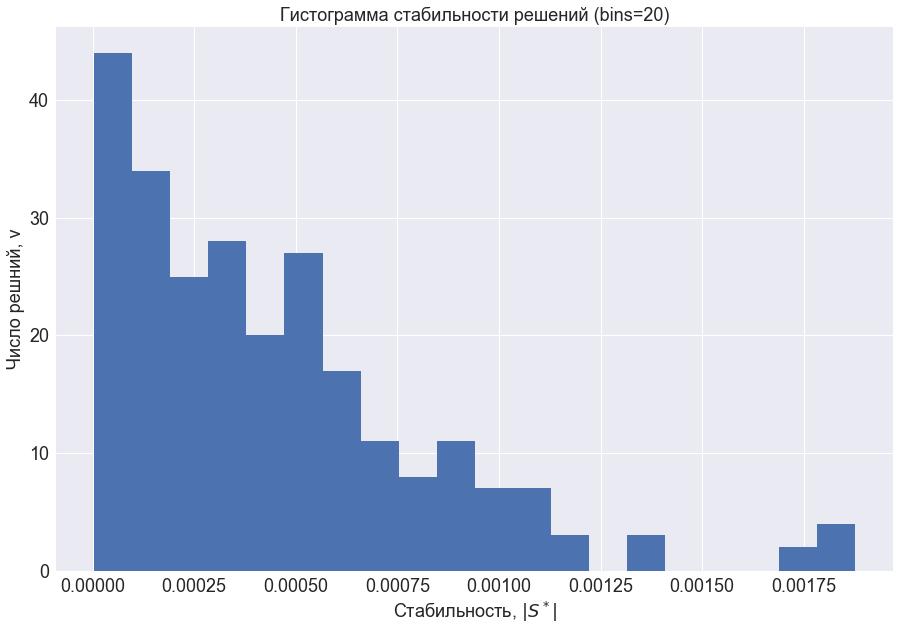

In [75]:
bins = 20
plot_hist(lr, df['Stability'], bins, True)

plt.savefig(picts_path+'11.png')

Что делать с этой характеристикой? Какие решения оказываются нам более полезными, а какие менее?

Помимо топов, нам особо интересны те алгоритмы, которые либо крайне стабильные, либо же, крайне нестабильны. Первые интересны так как, в рамках решеня удалось выделить признаки, которые положительно влияют на устойчивость. Вторые интересны по аналогичным антонимичным причинам. 

Но нужно отметить, алгоритм должен также набирать достаточно большой скор либо по паблику, либо по прайвату, либо и по тому и по другому параметру вместе. В противном случае, он бесполезен, конечно.

Теперь, чтобы измерить такие характеристики, мы построим зависимость следующего толка. Во-первых, введём ориентацию для $S^*$.  В случае положительного $S^*$, модель выиграла на прайвате. В случае отрицательного $S^*$ -- проиграла на прайвате и переобучилась. $S^*$ -- эмпирическая величина, построенная на основе большого количества решений. $S$ -- множество всех точек $y=x$.

Во-вторых, посмотрим на зависимость $y^*(S^*)$. Эта зависимость в себе агрегирует приватный скор и неявно публичный скор, а также степень переобученности (она может быть как отрицательной, так и положительной).

Взглянем на распределение. Нечто, похожее на Гаусса.

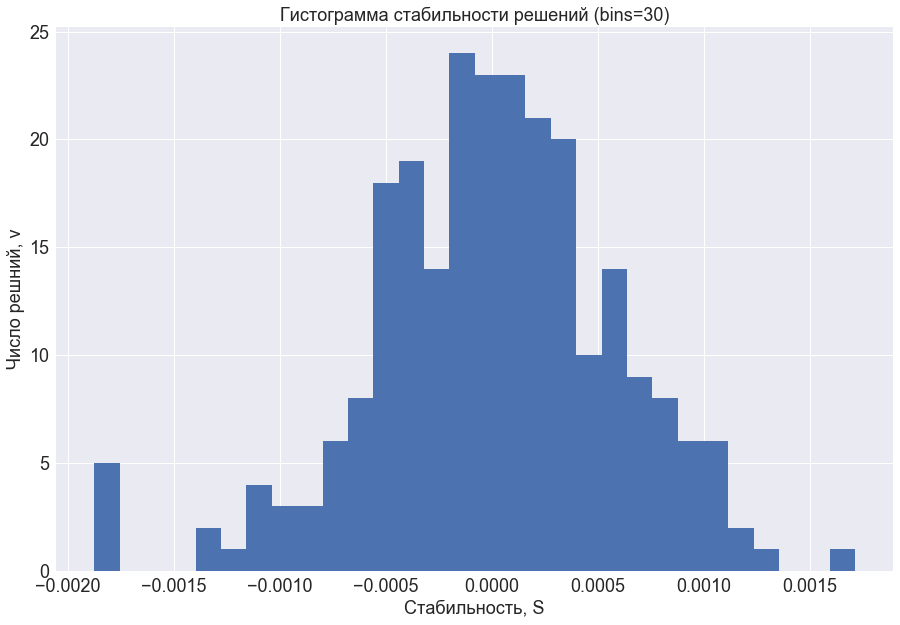

In [40]:
bins = 30
plot_hist(lr, df['Stability'], bins, False)
plt.savefig(picts_path+'12.png')

Теперь давайте построим зависимость $y^*(S^*)$. И здесь важный факт: у всех топов, кроме 3-его места (об этом решении мы ещё поговорим отдельно), довольно низкая стабильность решения. В частности, у Константина Николаева, который использовал не сотни признаков, а всего 52. Казалось бы, его решение должно быть особенно устойчивым. Но нет.

In [41]:
shifts = [
    [-0.00018, 0.00002],
    [-0.00005, 0.00002], 
    [-0.0002, -0.0009],
]
count = len(shifts)
text = df.sort_values('PrivateScore')['Name'].values[:count]
v = df.sort_values('PrivateScore')[['Stability', 'PrivateScore']].values
s, p = v[:count, 0], v[:count, 1]

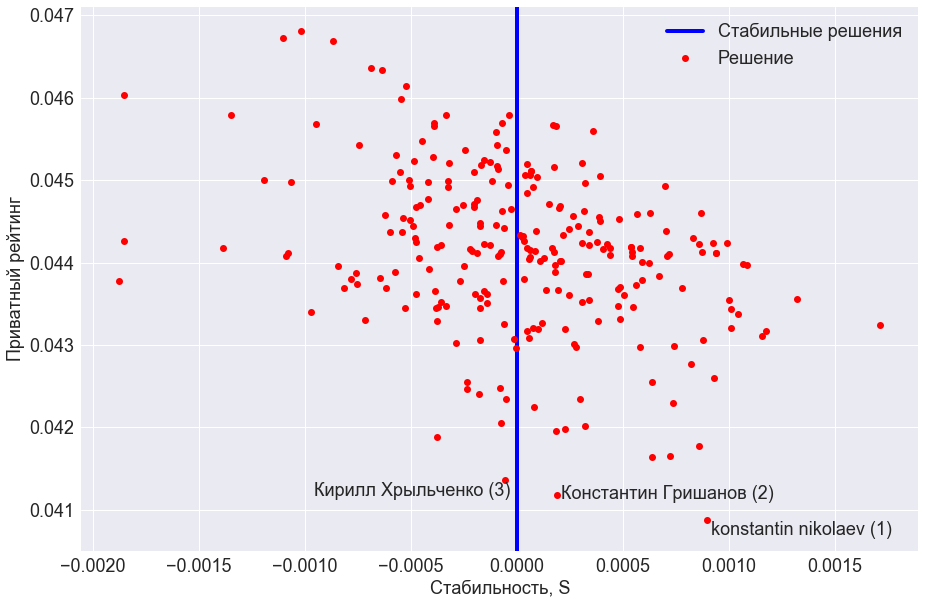

In [42]:
plt.figure(figsize=figsize_ordinary)
plt.plot([0, 0], [0, 1], 'b-', linewidth=linewidth, label='Стабильные решения')
plt.plot(df['Stability'], df['PrivateScore'], 'r.', markersize=markersize_ordinary, label='Решение')
plt.xlabel('Стабильность, S', fontsize=fontsize)
plt.ylabel('Приватный рейтинг', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim([0.0405, 0.0471])
plt.legend(fontsize=fontsize)
i = 0
for t, x0, y0 in zip(text, s, p):
    plt.text(s=t[:-1]+str(' (%d)' % (i+1)), x=x0+shifts[i][1], y=y0+shifts[i][0], fontsize=fontsize)
    i += 1
plt.grid(True)
plt.savefig(picts_path+'13.png')

In [43]:
count = 10
new_df = df.sort_values('PrivateScore')[['Name', 'Stability', 'PublicScore', 'PrivateScore']].iloc[:count].reset_index()
new_df[new_df.columns[1:]]

,Name,Stability,PublicScore,PrivateScore
0,konstantin nikolaev\n,0.000898,0.041601,0.040871
1,Константин Гришанов\n,0.000189,0.041313,0.041176
2,Кирилл Хрыльченко\n,-0.000057,0.041321,0.041360
3,Павел Логачев\n,0.000636,0.042392,0.041634
4,Максим Лукьяненко\n,0.000723,0.042504,0.041652
5,Владимир Сапачев\n,0.000857,0.042801,0.041770
6,Максим Шевченко\n,-0.000377,0.041727,0.041886
7,Владимир Бугаевский\n,0.000185,0.042376,0.041949
8,Андрей Педченко\n,0.000225,0.042460,0.041981
9,Сергей Старицын\n,0.000322,0.042601,0.042013


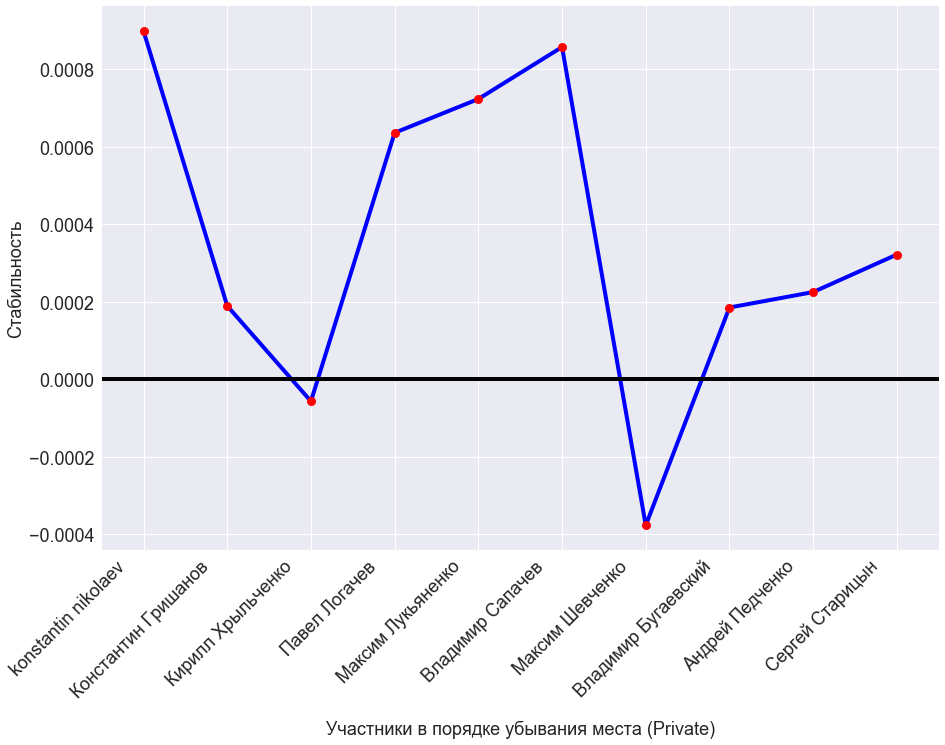

In [44]:
v = df.sort_values('PrivateScore')[['Stability', 'PrivateScore']].values
text = df.sort_values('PrivateScore')['Name'].values[:count]
s, p = v[:count, 0], v[:count, 1]

plt.figure(figsize=figsize_ordinary)
plt.plot(s, 'b-', linewidth=linewidth)
plt.plot([-1, len(text)+1], [0, 0], 'k-', linewidth=linewidth)
plt.plot(s, 'r.', linewidth=linewidth, markersize=18)
plt.xticks(np.linspace(0, len(s), len(s)+1), text, rotation=45, fontsize=fontsize, horizontalalignment='right')
plt.yticks(fontsize=fontsize)
plt.xlabel('Участники в порядке убывания места (Private)', fontsize=fontsize)
plt.ylabel('Стабильность', fontsize=fontsize)
plt.xlim([-0.5, count-0.5])
plt.grid(True)
plt.savefig(picts_path+'14.png')

### Исследование стабильности

Интересно, что стабильность -- непостоянная величина относительно теоритического ГМТ $y=x$. Т.е. для алгоритмов различной точности, она ведёт себя по-разному. От чего это зависит? Понятно, что алгоритмы строятся на основе данных и частично зависят от способа их построения. Принебрегая тем, что способ построения может как-то влиять на стабильность, можно сделать вывод, что $S^*(D)$. Почему происходит так, что $S^*(D)$ отклоняется от $S$? Это связано с различными распределениями тестовой и обучающих выборок. При этом, достигая определённой точности, алгоритм как бы достигает оптимума и становится наиболее устойчивым к определённым типам данных. Рассмотрим наш случай. Двигаясь вдоль ГМТ $y^*(x)$ в сторону точки стабильности, мы будем 

Какой вывод можно сделать из этого? Имея достаточно полный набор данных, следует выбирать не алгоритмы с максимальным скором, а модели, которые принадлежат множеству $\{y^*\} \cap \{y\}$. Ведь именно в них они оказываются наиболее устойчивыми.

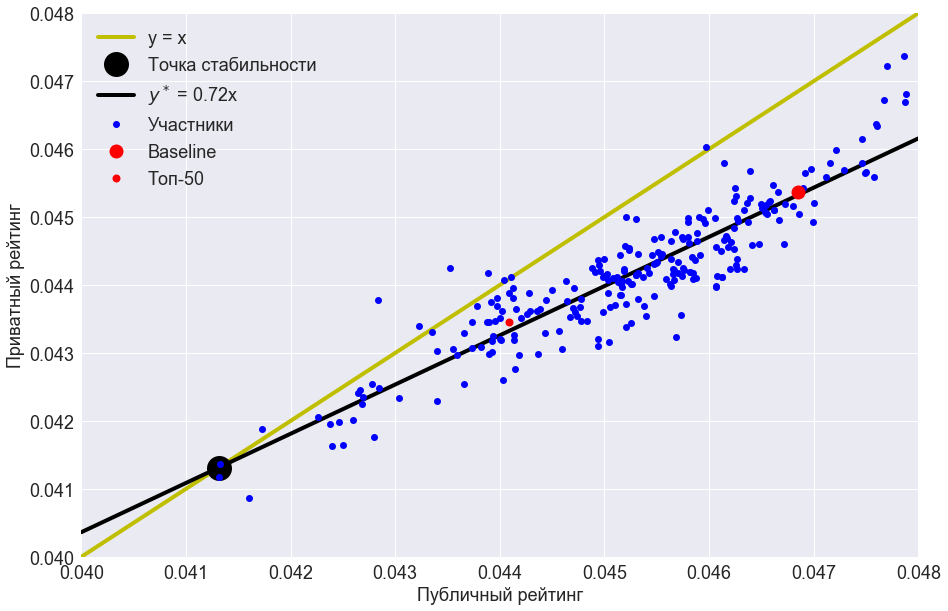

In [87]:
x_min, x_max = 0.04, 0.048
y_min, y_max = 0.04, 0.048
plt.figure(figsize=figsize_ordinary)

plt.plot(np.linspace(x_min, x_max, 2), np.linspace(y_min, y_max, 2), 'y', label='y = x', linewidth=linewidth)

xSt = lr.intercept_[0] / (1 - lr.coef_[0])
plt.plot(xSt, xSt, 'ko', markersize=25, label='Точка стабильности')

plt.plot([x_min, x_max], lr.predict([[x_min], [x_max]]), 'k-', label='$y^*$ = %.2fx' % lr.coef_, linewidth=linewidth)
plt.plot(df['PublicScore'], df['PrivateScore'], 'b.', markersize=markersize_ordinary, label='Участники')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('Публичный рейтинг', fontsize=fontsize)
plt.ylabel('Приватный рейтинг', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

xPub, yPub = get_coords_by_name('Baseline')
plt.plot(xPub, yPub, 'ro', markersize=markersize_ordinary, label='Baseline')
xPr, yPr = get_coords_by_name('Top-50')
plt.plot(xPr, yPr, 'r.', markersize=16, label='Топ-50')


plt.legend(fontsize=fontsize)
plt.grid(True)

plt.savefig(picts_path+'15.png')

По аналогии с тем, как мы определяли стабильность для алгоритмов, можно определить отличие тестовой и обучающей выборки.

TODO: [число обусловленности](https://ru.wikipedia.org/wiki/%D0%A7%D0%B8%D1%81%D0%BB%D0%BE_%D0%BE%D0%B1%D1%83%D1%81%D0%BB%D0%BE%D0%B2%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8)

Мне не совсем понятно, почему в рамках соревнований не используют приватную cv вместо hold out. Так была бы возможность избавиться от шафла, который регулярно наблюдается в соревнованиях по ML.

Todo: опредилили стабильность для приватного множества. А что насчёт для стабильности в целом?

Todo: насколько сильно отличается приват и паблик?

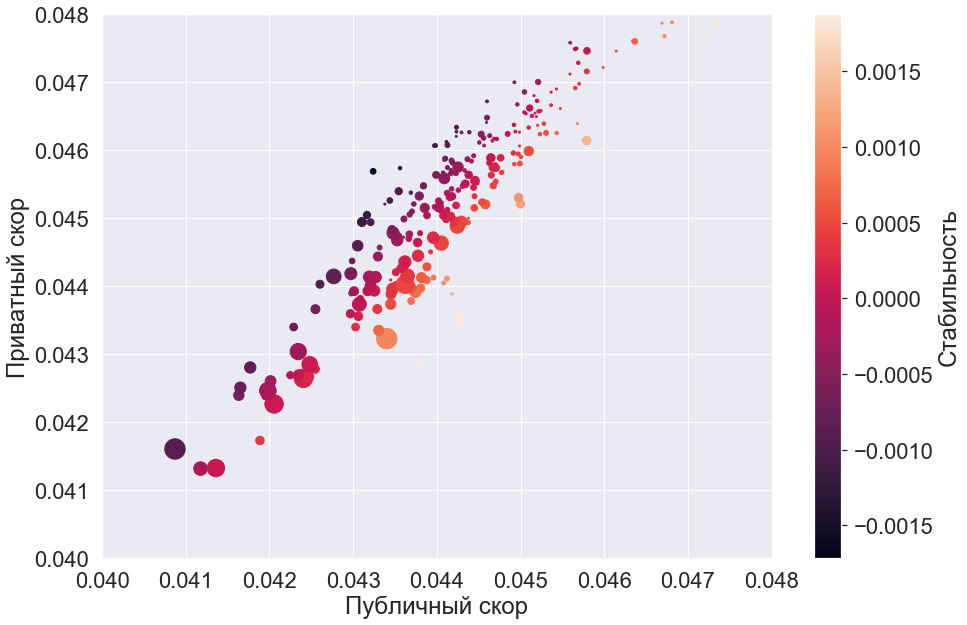

In [39]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
fig = plt.figure(figsize=figsize_ordinary)
sns.set(font_scale=2)
ax = plt.scatter(
    x=df["PrivateScore"], y=df["PublicScore"], c=-df["Stability"], s=4 * df["CountSubmission"]
)
x_min, x_max = 0.04, 0.048
y_min, y_max = 0.04, 0.048
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('Публичный скор')
plt.ylabel('Приватный скор')
plt.colorbar(ax, label='Стабильность')
plt.grid(True)
plt.savefig('10.png')